## Show difference between 3 subjects in keyboard dataset

In [126]:
import pandas as pd
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from q2_anomaly_detection.datasets import DietInterventionStudy
from q2_anomaly_detection.transforms import Rarefaction, CLR
from q2_anomaly_detection.benchmark import Benchmark
from q2_anomaly_detection.utils import as_dense
%matplotlib inline

In [127]:
RANDOM_SEED = 825
RAREFACTION_DEPTH = 1000

In [128]:
iso = Pipeline(steps=[
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('IF', IsolationForest(contamination="auto")),
])
lof = Pipeline(steps=[
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        )
     ),
])
lof_jaccard = Pipeline(steps=[
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        metric='jaccard',
        )
     ),
])
ocsvm = Pipeline(steps=[
    ('rarefy', Rarefaction(RAREFACTION_DEPTH,
                           replace=True,
                           )),
    ('SVM', OneClassSVM(gamma='auto')
     ),
])

iso_clr = Pipeline(steps=[
    ('clr', CLR()),
    ('IF', IsolationForest(contamination="auto")),
])
lof_clr = Pipeline(steps=[
    ('clr', CLR()),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        )
     ),
])
lof_jaccard_clr = Pipeline(steps=[
    ('clr', CLR()),
    ('LOF', LocalOutlierFactor(
        novelty=True,
        contamination="auto",
        metric='jaccard',
        )
     ),
])
ocsvm_clr = Pipeline(steps=[
    ('clr', CLR()),
    ('SVM', OneClassSVM(gamma='auto')
     ),
])

In [129]:
# CONVENTION: anomaly scores should be transformed onto (0, 1) where 1 is
#  least anomalous and 0 is the most anomalous
models = {
    'IF': {
        'model': iso,
    },
    'LOF': {
        'model': lof,
    },
    'LOF-jaccard': {
        'model': lof_jaccard,
    },
    'ocsvm': {
        'model': ocsvm,
    },
    'IF-clr': {
        'model': iso_clr,
    },
    'LOF-clr': {
        'model': lof_clr,
    },
    'LOF-jaccard-clr': {
        'model': lof_jaccard_clr,
    },
    'ocsvm-clr': {
        'model': ocsvm_clr,
    },
}

In [130]:
# qiita study 232 with trimming to 90 bp and pick closed reference on 97 otus tree
dataset = DietInterventionStudy('data/diet_intervention')

Files already downloaded and verified


In [131]:
table = dataset['table']

In [132]:
table.shape

(7107, 408)

In [133]:
metadata_all = dataset['metadata']

In [134]:
def construct_category(metadata):
    metadata['host_subject_id_for_plant'] = np.nan
    plant_samples = metadata.index[metadata.diet == 'Plant']
    metadata.loc[:, 'host_subject_id_for_plant'].loc[plant_samples] = metadata.host_subject_id[
        plant_samples].to_numpy()
    
    metadata['diet_for_subsample'] = np.nan
    keep_diet_indices = metadata['diet'].sample(len(metadata) // 2).index
    metadata.loc[:, 'diet_for_subsample'].loc[keep_diet_indices] = metadata.diet[keep_diet_indices].to_numpy()


def subset_metadata(metadata_all, table):
    table_ids = set(table.ids())

    # also remove anything that does not have more than RAREFACTION_DEPTH counts
    #  in both 'Plant' and 'Meat'
    table_sum = table.sum(axis='sample')

    insufficient_count_ids = table.ids('sample')[table_sum < RAREFACTION_DEPTH]

    table_ids -= set(insufficient_count_ids)


    metadata = metadata_all.query('host_common_name == "human" & sample_name in @table_ids &'
                                  'diet in ["Plant", "Animal"]'
                                 )
    
    diets_present = metadata[['host_subject_id', 'diet']].groupby('host_subject_id').agg(set)
    diets_sufficient = diets_present.apply(lambda diets: diets >= {'Plant', 'Animal'})
    sufficient_ids = diets_sufficient.loc[diets_sufficient['diet']].index
    
    metadata = metadata.query('host_subject_id in @sufficient_ids')

    return metadata

In [135]:
metadata = subset_metadata(metadata_all, table)

metadata = metadata.set_index('sample_name')

In [136]:
# TRAINING_CATEGORY = 'host_subject_id_for_plant'
# TRUTH_CATEGORY = 'host_subject_id'
# INTEREST_VARIABLE = 'diet'


TRAINING_CATEGORY = 'diet_for_subsample'
TRUTH_CATEGORY = 'diet'
INTEREST_VARIABLE = 'diet'

In [137]:
metadata[INTEREST_VARIABLE].unique()


array(['Plant', 'Animal'], dtype=object)

In [138]:
construct_category(metadata)

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [139]:
table.filter(metadata.index, axis='sample')

7107 x 210 <class 'biom.table.Table'> with 161609 nonzero entries (10% dense)

In [140]:
np.random.seed(RANDOM_SEED)
subtable = table  # table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [141]:
subtable.shape

(7107, 210)

In [142]:
study_ids = subtable.ids('sample')

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


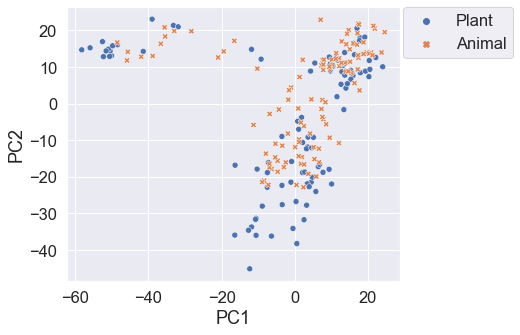

In [154]:
# rarefied_table = Rarefaction(RAREFACTION_DEPTH).fit_transform(as_dense(subtable).astype(int))
# dm = pdist(rarefied_table, metric='jaccard')
table_for_pcoa = CLR().fit_transform(as_dense(subtable))
dm = pdist(table_for_pcoa, metric='euclidean')

pcoa_results = pcoa(dm)

pcoa_results.samples.index = study_ids

pcoa_with_metadata = pcoa_results.samples.join(metadata)

plt.subplots(figsize=(10, 5))
ax = sns.scatterplot('PC1', 'PC2',
                     hue=TRUTH_CATEGORY,
                     style=INTEREST_VARIABLE,
                     data=pcoa_with_metadata
                     )
ax.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.savefig('results/clr-pcoa.png')
plt.tight_layout()

## Show the results of an anomaly detection algorithm of one class v. rest


In [144]:
submetadata.shape

(210, 43)

In [145]:
submetadata.groupby([TRUTH_CATEGORY, 'diet']).agg('count')

,,collection_date_publication,collection_time,collection_timestamp,country,day,description,elevation,empo_1,empo_2,empo_3,...,qiita_study_id,sample_type,scientific_name,sex,subjdiet,subjectfood,taxon_id,title,host_subject_id_for_plant,diet_for_subsample
diet,diet,,,,,,,,,,,,,,,,,,,,,
Animal,Animal,111,93,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,0,53
Plant,Plant,99,74,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,52


In [146]:
benchmark = Benchmark(models)
all_results = benchmark.benchmarking_loop(subtable, submetadata, TRUTH_CATEGORY, TRAINING_CATEGORY)



/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/garmstro/miniconda3/e

In [147]:
res_df = all_results.long_form()

In [148]:
res_with_pc = res_df.reset_index().join(
    pcoa_results.samples[['PC1', 'PC2', 'PC3']], on='sample_id'
).join(
    metadata[[INTEREST_VARIABLE]], on='sample_id'
)

In [149]:
pd.set_option("display.max_rows", 101)
all_results.short_form().sort_values('avg_prec', ascending=False)


,model_name,category,roc_auc,avg_prec
15,ocsvm-clr,Animal,0.733368,0.844718
6,ocsvm,Plant,0.688902,0.822531
9,IF-clr,Animal,0.684431,0.815693
11,LOF-clr,Animal,0.679990,0.805392
0,IF,Plant,0.562392,0.730155
12,LOF-jaccard-clr,Plant,0.500000,0.702532
4,LOF-jaccard,Plant,0.506805,0.694851
2,LOF,Plant,0.472398,0.680143
5,LOF-jaccard,Animal,0.540404,0.676184
14,ocsvm-clr,Plant,0.419398,0.654805


/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


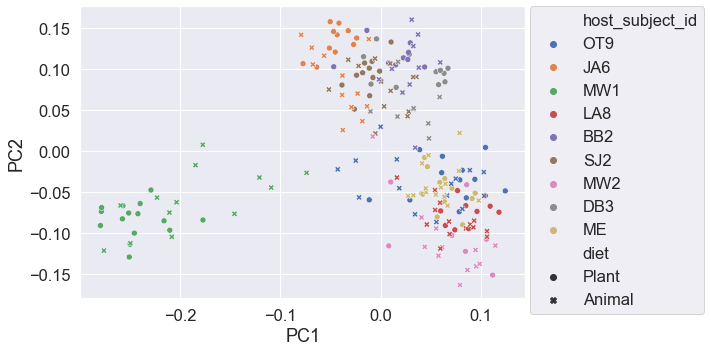

In [150]:
plt.subplots(figsize=(10, 5))
sns.scatterplot('PC1', 'PC2',
                hue='host_subject_id',
                style=INTEREST_VARIABLE,
                data=pcoa_with_metadata)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()

In [151]:
sns.set(font_scale=1.5)

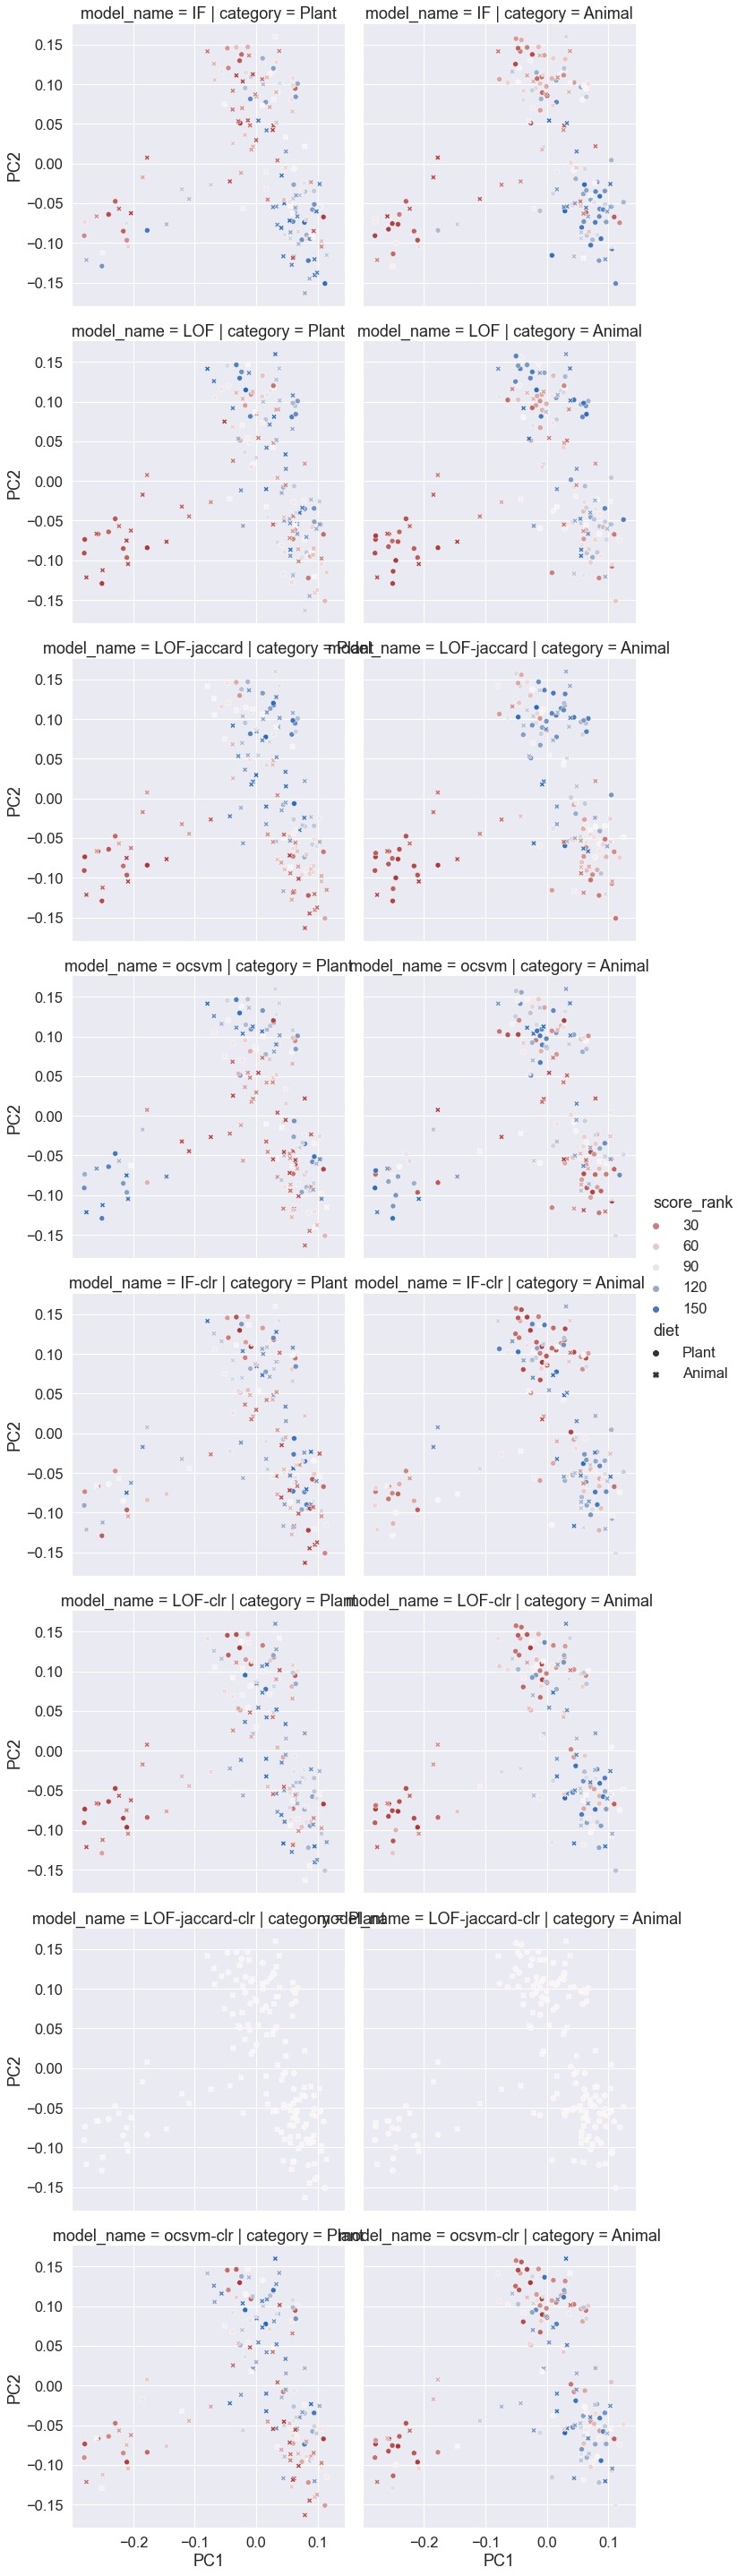

In [152]:
ax = sns.relplot(x='PC1', y='PC2',
            data=res_with_pc,
            col='category',
            row='model_name',
            hue='score_rank',
            palette='vlag_r',
            style=INTEREST_VARIABLE,
            aspect=1,
           )
